# 課題
## Car Fuel Consumption
https://www.kaggle.com/anderas/car-consume

## 目的（ゴール）

### DAY1
- 目的変数と説明変数の関係を確認するためのグラフを作成
- 目的変数を説明するのに有効そうな説明変数を見つける
- DAY1で学んだアルゴリズムを利用する
    - 回帰問題ー＞線形回帰
    - 質的変数が扱えないアルゴリズムを使う場合、ダミー変数に置き換え
- 予測精度または識別精度を確認する
    - 回帰問題ー＞MSE、RMSE、MAE


### DAY2、DAY3
- 前処理の改善
    - 前処理の改善と、欠測値と異常値を適切に処理する
        - DAY2
            - 正規化 / 標準化
            - 無相関化 / 白色化
        - DAY3
            - 特徴選択
        
- モデル
    - DAY2、3で学んだアルゴリズムを利用してモデルをつくり、DAY1宿題提出時の精度と比較する
        - DAY2
            - 線形回帰の正則化(L1、L2、ElasticNet)
            - サポートベクターマシン(線形、非線形）
                - 回帰->SVR使う
        - DAY3
            - 木モデル(決定木・ランダムフォレスト、アダブースト、バギング) 
            - ニューラルネットワーク

- 評価
    - 交差検証、ホールドアウト法などで汎化性能を確認する
    - 交差検証によるパラメータチューニングを行う
        - グリッドサーチを使って最適なパラメタを見つける
    - パラメータチューニング後のモデルによって、精度および結果の評価を行う
        - グリッドサーチで見つけたモデル・パラメタを使用し精度を測る

- まとめ
    - 前回から取り組んだ内容・工夫、精度がどのように変化したかをまとめる

## データセット

### 使用するデータセット
measurements.csv <br>

### 各項目の説明
| columns| 説明| 内容| 種類|
|:-----------|------------:|:------------:|:------------:|
| distance| 距離| km| 量的変数|
| consume| 消費量| L / 100km| 量的変数|
| speed| 平均速度| km/h| 量的変数|
| temp_inside| 内気温| ℃| 量的変数|
| temp_outside| 外気温|　℃| 量的変数|
| specials| スペシャル| 雨雪などの天気 <br>エアコンON/OFF| 質的変数|
| gas_type| ガソリンタイプ|　SP98、E10| 質的変数|
| AC| エアコン| 'ON':1、'OFF':0| 質的変数|
| rain| 雨| '雨':1、'雨じゃない':0| 質的変数|
| sun| 晴れ| '晴れ':1、'晴れじゃない':0| 質的変数|
| refill liters| リッター補充時の金額| ユーロ？| 量的変数|
| refill gas| ガソリン補充の種類| SP98、E10| 質的変数|

## ソースコード

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.svm import SVR

from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils

from tqdm import tqdm_notebook as tqdm

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# ワーニングを消すおまじない。課題提出時だけ有効にする
import warnings
warnings.filterwarnings('ignore')

In [3]:
# データ読み取り
df_data = pd.read_csv('./data/measurements.csv')

In [4]:
# 取得したデータ確認
display(df_data.head())
display(df_data.dtypes)
display(df_data.describe())

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


distance         object
consume          object
speed             int64
temp_inside      object
temp_outside      int64
specials         object
gas_type         object
AC                int64
rain              int64
sun               int64
refill liters    object
refill gas       object
dtype: object

,speed,temp_outside,AC,rain,sun
count,388.000000,388.000000,388.000000,388.000000,388.000000
mean,41.927835,11.358247,0.077320,0.123711,0.082474
std,13.598524,6.991542,0.267443,0.329677,0.275441
min,14.000000,-5.000000,0.000000,0.000000,0.000000
25%,32.750000,7.000000,0.000000,0.000000,0.000000
50%,40.500000,10.000000,0.000000,0.000000,0.000000
75%,50.000000,16.000000,0.000000,0.000000,0.000000
max,90.000000,31.000000,1.000000,1.000000,1.000000


### データの整形

In [5]:
# 小数点表示を','から'.'に変更
df_data = df_data.replace('\,', '.', regex=True)

# 文字列から数値に変換
df_data['distance'] = df_data['distance'].astype(float)
df_data['consume'] = df_data['consume'].astype(float)
df_data['speed'] = df_data['speed'].astype(float)
df_data['temp_inside'] = df_data['temp_inside'].astype(float)
df_data['temp_outside'] = df_data['temp_outside'].astype(float)
df_data['refill liters'] = df_data['refill liters'].astype(float)

# 'SP98':0, 'E10':1に変換
df_data.loc[df_data['gas_type'] == 'SP98', 'gas_type'] = 0
df_data.loc[df_data['gas_type'] == 'E10', 'gas_type'] = 1
df_data.loc[df_data['refill gas'] == 'SP98', 'refill gas'] = 0
df_data.loc[df_data['refill gas'] == 'E10', 'refill gas'] = 1

In [6]:
# スペシャルの中身確認
df_data['specials'].value_counts()

rain                  32
sun                   27
AC rain                9
ac                     8
AC                     6
snow                   3
sun ac                 3
AC Sun                 1
AC snow                1
ac rain                1
AC sun                 1
half rain half sun     1
Name: specials, dtype: int64

In [7]:
# '大文字小文字がバラバラなのでAC'と'sun'に統一
df_data.loc[df_data['specials'] == 'Sun', 'specials'] = 'sun'
df_data.loc[df_data['specials'] == 'ac', 'specials'] = 'AC'
df_data.loc[df_data['specials'] == 'AC Sun', 'specials'] = 'AC sun'
df_data.loc[df_data['specials'] == 'sun ac', 'specials'] = 'AC sun'
df_data.loc[df_data['specials'] == 'ac rain', 'specials'] = 'AC rain'
df_data['specials'].value_counts()

rain                  32
sun                   27
AC                    14
AC rain               10
AC sun                 5
snow                   3
AC snow                1
half rain half sun     1
Name: specials, dtype: int64

In [8]:
# 'specials’をダミー変数に置き換え
df_specials = pd.get_dummies(df_data['specials'])
df_specials.columns = [
    '[s]AC', '[s]AC rain', '[s]AC snow', '[s]AC sun', '[s]half rain half sun', '[s]rain', '[s]snow', '[s]sun'
]
df_data = pd.concat([df_data, df_specials], axis=1)

# ダミー変数に置き換えたので'specials'は削除
df_data = df_data.drop(['specials'], axis=1)

In [9]:
# 欠損値確認
df_data.isnull().sum()

distance                   0
consume                    0
speed                      0
temp_inside               12
temp_outside               0
gas_type                   0
AC                         0
rain                       0
sun                        0
refill liters            375
refill gas               375
[s]AC                      0
[s]AC rain                 0
[s]AC snow                 0
[s]AC sun                  0
[s]half rain half sun      0
[s]rain                    0
[s]snow                    0
[s]sun                     0
dtype: int64

In [10]:
# 暖房がまったく使用されなかった場合はフラグを立てる説明変数を作成
df_data['heating_off'] = df_data['temp_inside'].isnull()
df_data['heating_off'] = df_data['heating_off'].apply(float)

# 加熱が完全に止まったら、内部温度を外気温度
df_data['temp_inside'].fillna(df_data['temp_outside'], inplace=True)

# 'refill liters','refil gas'は欠損値多すぎるので削除
df_data = df_data.drop('refill liters', axis=1)
df_data = df_data.drop('refill gas', axis=1)

In [11]:
# AC,rain,sunとspecialのAC,rain,sunはまとめることが出来そう
print("'AC'と'[s]AC'の比較")
print((df_data['AC'] == df_data['[s]AC']).value_counts())

print("\n'rain'と'[s]rain'の比較")
print((df_data['rain'] == df_data['[s]rain']).value_counts())

print("\n'sun'と'[s]sun'の比較")
print((df_data['sun'] == df_data['[s]sun']).value_counts())

'AC'と'[s]AC'の比較
True     370
False     18
dtype: int64

'rain'と'[s]rain'の比較
True     372
False     16
dtype: int64

'sun'と'[s]sun'の比較
True     383
False      5
dtype: int64


In [12]:
# 差分があった。どちらかに漏れがある可能性があるので、「and」を取り、確実なデータのみ抽出した'[new]XXX'を新規に作成する
df_data['[new]AC'] = (df_data['AC'] & df_data['[s]AC'])
df_data['[new]rain'] = (df_data['rain'] & df_data['[s]rain'])
df_data['[new]sun'] = (df_data['sun'] & df_data['[s]sun'])

In [13]:
# temp_insideとtemp_outsideは同じ温度を表しているので関連性がありそう。差分を取り、新たな説明変数とする
df_data['temp_diff'] = df_data['temp_inside'] - df_data['temp_outside']

# distanceとspeedから乗車時間が作れるので新たな説明変数とする
df_data['time_h'] = df_data['distance'] / df_data['speed']

In [14]:
# 型の統一（量的変数はfloat64、質的変数はuint8）
df_data['gas_type'] = df_data['gas_type'].astype('uint8')
df_data['AC'] = df_data['AC'].astype('uint8')
df_data['rain'] = df_data['rain'].astype('uint8')
df_data['sun'] = df_data['sun'].astype('uint8')
df_data['heating_off'] = df_data['heating_off'].astype('uint8')
df_data['[new]AC'] = df_data['[new]AC'].astype('uint8')
df_data['[new]rain'] = df_data['[new]rain'].astype('uint8')
df_data['[new]sun'] = df_data['[new]sun'].astype('uint8')

display(df_data.dtypes)

distance                 float64
consume                  float64
speed                    float64
temp_inside              float64
temp_outside             float64
gas_type                   uint8
AC                         uint8
rain                       uint8
sun                        uint8
[s]AC                      uint8
[s]AC rain                 uint8
[s]AC snow                 uint8
[s]AC sun                  uint8
[s]half rain half sun      uint8
[s]rain                    uint8
[s]snow                    uint8
[s]sun                     uint8
heating_off                uint8
[new]AC                    uint8
[new]rain                  uint8
[new]sun                   uint8
temp_diff                float64
time_h                   float64
dtype: object

In [15]:
def decorrelation_data(data, calc_S_flg=True, S=None):
    """無相関化"""
    
    if calc_S_flg:
        # 分散・共分散を求める
        cov = np.cov(data, rowvar=0)

        # 分散共分散行列の固有ベクトルを用いて
        _, S = np.linalg.eig(cov)

    # データを無相関化
    data_decorr = np.dot(S.T, data.T).T

    return data_decorr, S

In [16]:
def decorrelation_between_exp_data(df_data, corr_num):
    '''指定する|相関係数|以上の説明変数を無相関化'''

    exp_corr = df_data.drop(['consume'], axis=1).corr()[
         (abs(df_data.corr()) >= corr_num) & (df_data.corr() != 1)
    ]
    
    display(exp_corr)
    sns.heatmap(exp_corr)
    
    # TODO もっと良いやり方あると思う
    # 相関が強い説明変数を無相関化
    removed_na_exp_corr = []

    # Noneを取り除く
    for column in exp_corr.columns:
        for i in exp_corr.index:
            if exp_corr.notna().loc[i, column]:
                removed_na_exp_corr.append([i, column, exp_corr.loc[i, column]])

    # 同じデータを取り除く
    tmp = []
    for i in range(len(removed_na_exp_corr) - 1):
        for j in np.arange(i, len(removed_na_exp_corr)):
            if (removed_na_exp_corr[i][0] == removed_na_exp_corr[j][1]) and (removed_na_exp_corr[i][1] == removed_na_exp_corr[j][0]):
                tmp.append(removed_na_exp_corr[i])
    removed_na_exp_corr = tmp
    
    # 質的変数は取り除く
    tmp = []
    for i in range(len(removed_na_exp_corr)):
        if (df_data[removed_na_exp_corr[i][0]].dtypes == 'float64') and (df_data[removed_na_exp_corr[i][1]].dtypes == 'float64'):
            tmp.append(removed_na_exp_corr[i])
    removed_na_exp_corr = tmp
    
    # 無相関化
    for i in range(len(removed_na_exp_corr)):
        df_data[[removed_na_exp_corr[i][0], removed_na_exp_corr[i][1]]] = decorrelation_data(
            df_data[[removed_na_exp_corr[i][0], removed_na_exp_corr[i][1]]]
        )

In [17]:
# 指定する|相関係数|以上の説明変数を無相関化
# TODO train,test分割後に処理を移動
# decorrelation_between_exp_data(df_data, 0.9)

In [18]:
def standard_scaler_data(df_data):
    """標準化"""

    stdsc = StandardScaler()
    for column in df_data.columns:
        # 量的変数だったら標準化、'consume' は目的変数なので標準化しない
        if (df_data[column].dtypes == 'float64') & (column != 'consume'):
            df_data[column] = stdsc.fit_transform(df_data[[column]].values)

    return df_data

In [19]:
# 標準化
# TODO train,test分割後に処理を移動
# df_data = standard_scaler_data(df_data)

### グラフを可視化

In [20]:
display(df_data.head())

# 散布図行列は表示項目が多すぎて見づらいため省略
# pd.plotting.scatter_matrix(df_data, figsize=(10,10))
# plt.show()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,[s]AC,...,[s]half rain half sun,[s]rain,[s]snow,[s]sun,heating_off,[new]AC,[new]rain,[new]sun,temp_diff,time_h
0,28.0,5.0,26.0,21.5,12.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,9.5,1.076923
1,12.0,4.2,30.0,21.5,13.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,8.5,0.400000
2,11.2,5.5,38.0,21.5,15.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,6.5,0.294737
3,12.9,3.9,36.0,21.5,14.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,7.5,0.358333
4,18.5,4.5,46.0,21.5,15.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,6.5,0.402174


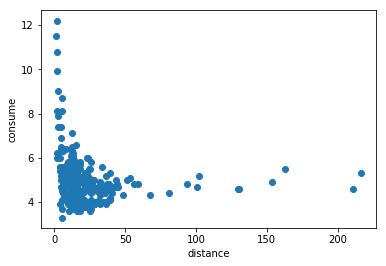

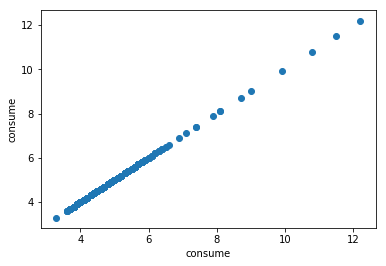

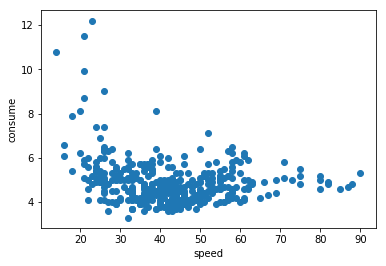

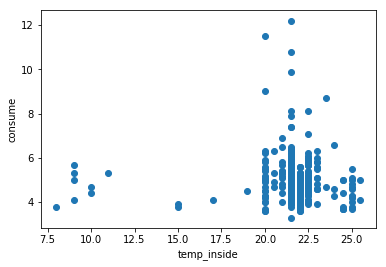

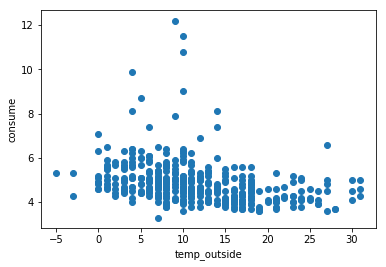

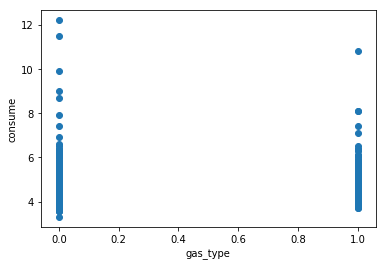

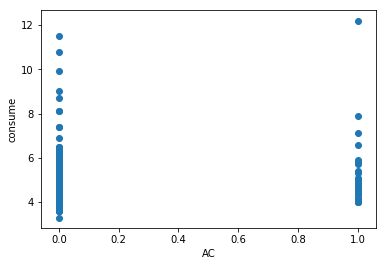

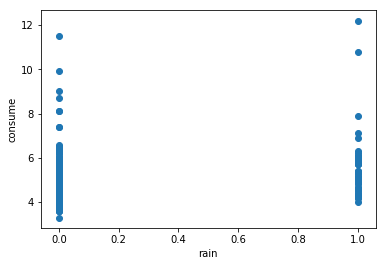

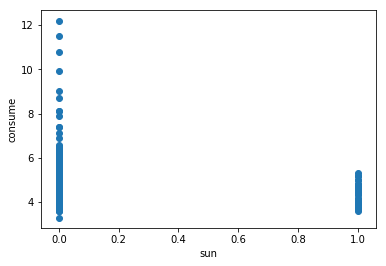

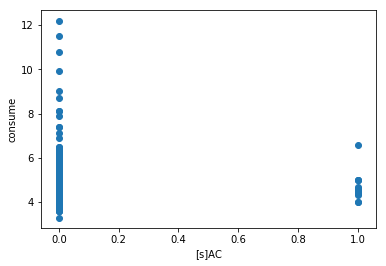

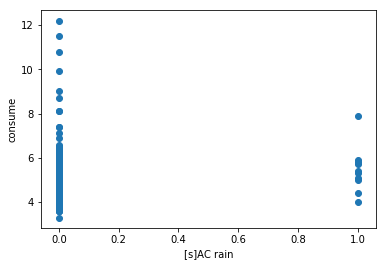

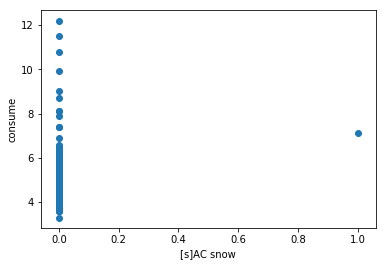

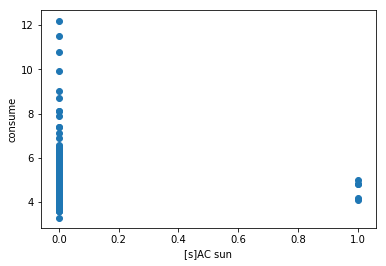

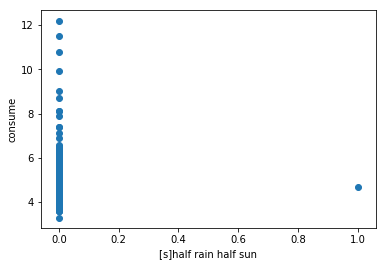

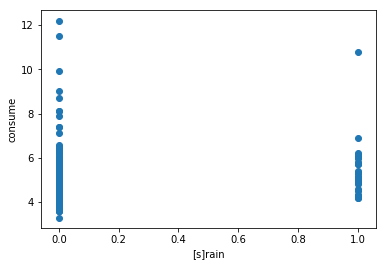

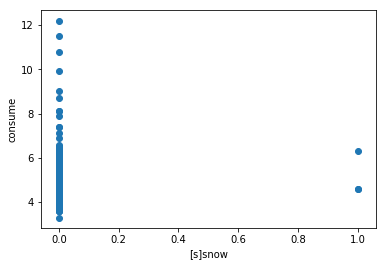

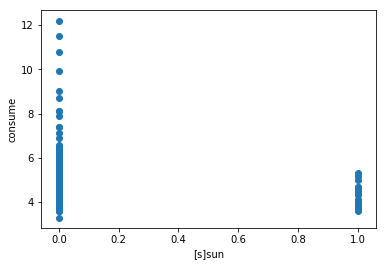

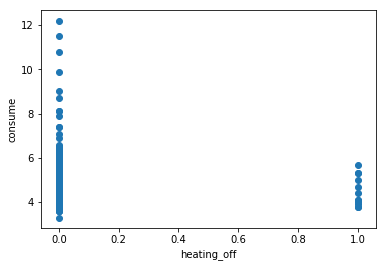

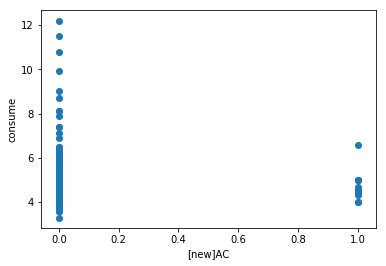

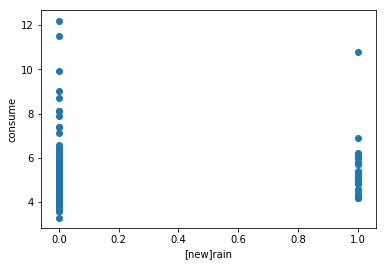

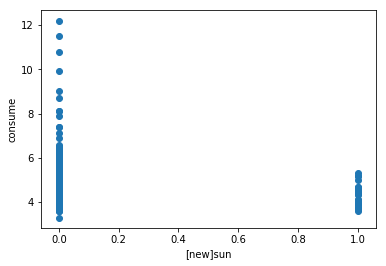

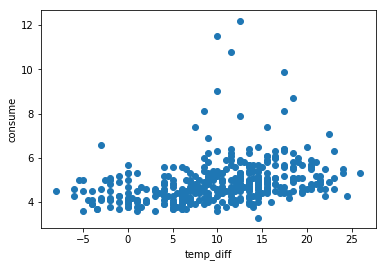

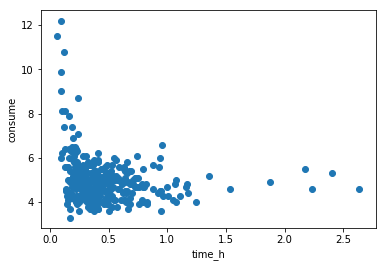

In [21]:
# consumeに絞って散布図表示してみる
for column in df_data.columns:
    plt.scatter(df_data[column], df_data['consume'])
    plt.xlabel(column)
    plt.ylabel('consume')
    plt.show()

[s]half rain half sun    0.010462
gas_type                 0.015327
[s]snow                  0.021755
temp_inside              0.035716
[s]AC sun                0.036804
[new]AC                  0.039709
[s]AC                    0.042500
heating_off              0.069953
[s]AC rain               0.084747
AC                       0.096591
[s]AC snow               0.107772
distance                 0.128967
[s]rain                  0.157122
[new]rain                0.157122
[s]sun                   0.168194
[new]sun                 0.168194
sun                      0.170667
time_h                   0.177825
speed                    0.227866
rain                     0.248118
temp_diff                0.313642
temp_outside             0.320811
consume                  1.000000
Name: consume, dtype: float64

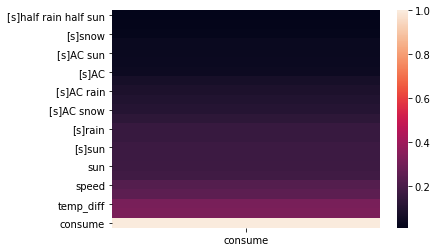

In [22]:
# 'consume'に絞って、相関係数、ヒートマップを可視化
consume_corr = df_data.corr()['consume']

# 相関係数の絶対値でソート
sorted_consume_corr = abs(consume_corr).sort_values(ascending=True)

display(sorted_consume_corr)
sns.heatmap(pd.DataFrame(sorted_consume_corr))

### 検証

#### 説明変数の選択
consumeとの相関係数（の絶対値）が大きいデータを選択すれば一般的には問題なさそうだが、念の為、最初は説明変数全てを選択し、徐々に説明変数の数を減らしながら精度を計測してみた。

In [23]:
def pre_process_for_divided_data(X_train, X_test):
    """X_train, X_testに対する前処理"""

# TODO 質的変数は無相関化しない、相関係数高いものだけ無相関化したい
    # 無相関化(X_train)
    if X_train.shape[1] >= 2:
        X_train, S = decorrelation_data(X_train)

    # 無相関化(X_test)・・・SはX_trainで計算したものを使う
    if X_test.shape[1] >= 2:
        X_test, _ = decorrelation_data(X_test, calc_S_flg=False, S=S)

# TODO 質的変数は標準化しない
    # 標準化
    stdsc = StandardScaler()
    X_train = stdsc.fit_transform(X_train)
    X_test = stdsc.transform(X_test)

    return X_train, X_test

In [24]:
def train_test_split_for_comparison(X, y):
    """
    受講者間のスコア比較用処理
    returnで返すX_test, y_testは、
    最後にMAE等の指標を測定する時のみ用いる。
    """

    test_size = 0.1

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=1234
    )
    
    return X_train, X_test, y_train, y_test

In [25]:
def evaluate_normal_precision(X, y, model, pre_process_flg=True):
    """訓練誤差のみ"""

    # 受講者間のスコア比較用処理
    X_train_for_comp, X_test_for_comp, y_train_for_comp, y_test_for_comp = train_test_split_for_comparison(X, y)
    
    if pre_process_flg:
        # X_train, X_testに対する前処理
        X_train_for_comp, X_test_for_comp = pre_process_for_divided_data(X_train_for_comp, X_test_for_comp)

    # モデルを学習
    model.fit(X_train_for_comp, y_train_for_comp)

    # 　精度の確認
    y_pred = model.predict(X_test_for_comp)

    mse = mean_squared_error(y_test_for_comp, y_pred)
    mae = mean_absolute_error(y_test_for_comp, y_pred)
    rmse = np.sqrt(mse)

#     print("MSE = {}".format(round(mse, 3)))
#     print("MAE = {}".format(round(mae, 3)))
#     print("RMSE = {}".format(round(rmse, 3)))

    return mse, mae, rmse

In [26]:
def evaluate_hold_out(X, y, model, pre_process_flg=True):
    """ホールドアウト法"""
    
    # 受講者間のスコア比較用処理
    X_train_for_comp, X_test_for_comp, y_train_for_comp, y_test_for_comp = train_test_split_for_comparison(X, y)

    if pre_process_flg:
        # X_train, X_testに対する前処理
        X_train_for_comp, X_test_for_comp = pre_process_for_divided_data(X_train_for_comp, X_test_for_comp)

    # 全データのうち、何%をテストデータにするか（今回は20%に設定）
    test_size = 0.2

    # ホールドアウト法を実行（テストデータはランダム選択）
    X_train, X_test, y_train, y_test = train_test_split(
        X_train_for_comp, y_train_for_comp, test_size=test_size, random_state=1234
    )

#     if pre_process_flg:
#         # X_train, X_testに対する前処理
#         X_train, X_test = pre_process_for_divided_data(X_train, X_test)

    # 学習用データを使ってモデルを学習
    model.fit(X_train, y_train)

    # 学習用データに対する予測を実行
    y_pred_train = model.predict(X_train_for_comp)

    # 訓練データに対するMAEを計算（訓練誤差の評価）
    predict_mae = mean_absolute_error(y_train_for_comp, y_pred_train)

    # テストデータに対する予測を実行
    y_pred_test = model.predict(X_test_for_comp)

    # テストデータに対するMAEを計算（汎化誤差の評価）
    test_mae = mean_absolute_error(y_test_for_comp, y_pred_test)

#     print("predict MAE = {}".format(round(predict_mae, 3)))
#     print("test MAE = {}".format(round(test_mae, 3)))

    return predict_mae, test_mae

In [27]:
def evaluate_cross_varidation(X, y, model, pre_process_flg=True):
    """クロスバリデーション法"""
    
    # 受講者間のスコア比較用処理
    X_train_for_comp, X_test_for_comp, y_train_for_comp, y_test_for_comp = train_test_split_for_comparison(X, y)

    if pre_process_flg:
        # X_train, X_testに対する前処理
        X_train_for_comp, X_test_for_comp = pre_process_for_divided_data(X_train_for_comp, X_test_for_comp)

    # グループ数を設定（今回は5分割）
    n_split = 5

    # テスト役を交代させながら学習と評価を繰り返す
    cross_valid_mae = 0
#     split_num = 1
    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X_train_for_comp, y_train_for_comp):
        X_train, y_train = X_train_for_comp[train_idx], y_train_for_comp[train_idx]
        X_test, y_test = X_train_for_comp[test_idx], y_train_for_comp[test_idx]

#         if pre_process_flg:
#             # X_train, X_testに対する前処理
#             X_train, X_test = pre_process_for_divided_data(X_train, X_test)

        # 学習用データを使ってモデルを学習
        model.fit(X_train, y_train)

        # テストデータに対する予測を実行
        y_pred_test = model.predict(X_test_for_comp)

        # テストデータに対するMAEを計算
        mae_fold = mean_absolute_error(y_test_for_comp, y_pred_test)
#         print("Fold{} MAE = {}".format(split_num, round(mae_fold, 3)))

        # 後で平均を取るためにMAEを加算
        cross_valid_mae += mae_fold
#         split_num += 1

    # MAEの平均値を最終的な汎化誤差値とする
    final_cv_mae = cross_valid_mae / n_split

#     print("Cross Validation MAE = {}".format(round(final_cv_mae, 3)))

    return final_cv_mae

In [28]:
def evaluate_grid_search(X, y, model, parameters, pre_process_flg=True):
    """クロスバリデーション法＋グリッドサーチ法"""

    # 受講者間のスコア比較用処理
    X_train_for_comp, X_test_for_comp, y_train_for_comp, y_test_for_comp = train_test_split_for_comparison(X, y)

    if pre_process_flg:
        # X_train, X_testに対する前処理
        X_train_for_comp, X_test_for_comp = pre_process_for_divided_data(X_train_for_comp, X_test_for_comp)

    # グループ数を設定（今回は5分割）
    n_split = 5

    tmp_gs_mae = 0
#     split_num = 1
    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X_train_for_comp, y_train_for_comp):
        X_train, y_train = X_train_for_comp[train_idx], y_train_for_comp[train_idx]
        X_test, y_test = X_train_for_comp[test_idx], y_train_for_comp[test_idx]

#         if pre_process_flg:
#             # X_train, X_testに対する前処理
#             X_train, X_test = pre_process_for_divided_data(X_train, X_test)

        est = GridSearchCV(model, parameters, cv=3)
        est.fit(X_train, y_train)

        final_gs_best_params = est.best_params_
        final_gs_best_score = est.best_score_

        #  モデル名を取得
        model_name = str(model).split('(')[0]

        # 最適パラメータを用いて識別する
        est2 = eval(model_name)(**est.best_params_)
        est2.fit(X_train, y_train)

        # テストデータに対する予測を実行
        y_pred_test = est2.predict(X_test_for_comp)

        # テストデータに対するMAEを計算
        tmp_gs_mae += mean_absolute_error(y_test_for_comp, y_pred_test)
#         print("Fold{} MAE = {}".format(split_num, round(mean_absolute_error(y_test_for_comp, y_pred_test), 3)))
#         split_num += 1
        
    # MAEの平均値を最終的な汎化誤差値とする
    final_gs_mae = tmp_gs_mae / n_split

#     print("best params = {}".format(final_gs_best_params))
#     print("best score = {}".format(final_gs_best_score))
#     print("Grid Search MAE = {}".format(round(final_gs_mae, 3)))

    return final_gs_mae, final_gs_best_params, final_gs_best_score

#### 評価したいモデルとパラメタを設定

In [29]:
def get_evaluate_models_and_params():
    """モデルとパラメタの設定"""
    
    evaluate_models = {}

    # 線形回帰 正則化なし
    evaluate_models['LinearRegression'] = {
        'model': LinearRegression(),
        'parameters': {
            'fit_intercept':[True, False],
            'normalize':[True, False]
        },
        'pre_process_flg':True
    }

    # 線形回帰　Ridge
    evaluate_models['Ridge'] = {
        'model': Ridge(),
        'parameters': {
            'alpha': [0.0, 1e-8, 1e-5, 1e-1, 1, 3, 7, 10]
        },
        'pre_process_flg':True
    }

    # 線形回帰　Lasso
    evaluate_models['Lasso'] = {
        'model': Lasso(),
        'parameters': {
            'alpha': [0.0, 1e-20, 1e-3, 1e-2, 1e-1, 1, 3, 7, 10],
# #         'max_iter':[1e7] <- TODOループが終わらなくなる
        },
        'pre_process_flg':True
    }

    # 線形回帰 ElasticNet
    evaluate_models['ElasticNet'] = {
        'model': ElasticNet(),
        'parameters': {
            'alpha': [0.0, 1e-20, 1e-3, 1e-2, 1e-1, 1, 3, 7, 10],
            'l1_ratio': [0, 0.1, 0.5, 1.0],
# #         'max_iter':[1e7] <-TODOループが終わらなくなる
        },
        'pre_process_flg':True
    }

    # SVR
    evaluate_models['SVR'] = {
        'model': SVR(),
        'parameters': {
            'kernel': ['linear', 'rbf'],
            'C': [1, 5, 10],
            'gamma': [1e-2, 1e-1, 1, 1e1, 1e2]
        },
        'pre_process_flg':True
    }

    # 決定木
    evaluate_models['DecisionTreeRegressor'] = {
        'model': DecisionTreeRegressor(),
        'parameters': {
            'criterion': ['mae'],
#             'max_depth': [None, 3, 5, 10],
#             'min_samples_split': [3, 5, 10],
#             'min_samples_leaf': [3, 5, 10],
            'random_state': [1234]
        },
        'pre_process_flg':False
    }

    # ランダムフォレスト
    evaluate_models['RandomForestRegressor'] = {
        'model': RandomForestRegressor(),
        'parameters': {
#             'n_estimators': [3, 10, 100, 1000, 10000],
#             'n_estimators': [10],
#             'n_jobs': [-1],
#             'criterion': ['mae'],
#             'max_depth': [None, 3, 5, 10],
#             'min_samples_split': [3, 5, 10],
#             'min_samples_leaf': [3, 5, 10],
            'random_state': [1234]
        },
        'pre_process_flg':False
    }

    # アダブースト
    evaluate_models['AdaBoostRegressor'] = {
        'model': AdaBoostRegressor(),
        'parameters': {
            'base_estimator': [
                DecisionTreeRegressor(
                    criterion="mae",
#                     max_depth=None,
#                     min_samples_leaf=3,
#                     min_samples_split=3, 
                    random_state=1234
                )
            ],
#             'n_estimators': [3, 10, 100, 1000, 10000],
#             'n_estimators': [10],
            'random_state': [1234]
        },
        'pre_process_flg':False
    }

    # バギング
    evaluate_models['BaggingRegressor'] = {
        'model': BaggingRegressor(),
        'parameters': {
            'base_estimator': [
                DecisionTreeRegressor(
                    criterion="mae",
#                     max_depth=None,
#                     min_samples_leaf=3,
#                     min_samples_split=3, 
                    random_state=1234
                )
            ],
#             'n_estimators': [3, 10, 100, 1000, 10000],
#             'n_estimators': [10],
            'max_samples': [0.3],
            'random_state': [1234]
        },
        'pre_process_flg':False
    }


    # TODO keras対応
    #     def reg_model():
    #         """keras用回帰モデル"""

    #         model = Sequential()
    #         model.add(Dense(out_dim, input_dim=4, activation='relu'))
    #         model.add(Dense(out_dim, activation='relu'))
    #         model.add(Dense(3, activation='softmax'))#最終層のactivationは変更しないこと    
    #         model.compile(loss='mean_absolute_error', optimizer='adam')
    #         return model

    #     # keras
    #     evaluate_models['KerasRegressor'] = {
    #         'model': KerasRegressor(
    #             build_fn=reg_model, 
    #             epochs=100, 
    #             batch_size=10, 
    #             verbose=0
    #         ),
    #         'parameters': dict(
    #             activation=["relu", "sigmoid"], 
    #             optimizer=["adam", "adagrad"], 
    #             nb_epoch=[10, 25], 
    #             batch_size=[5, 10]
    #         )
    #     }

    return evaluate_models

### 特徴選択-相関係数の値で説明変数を選択する方法(normal法)
#### モデルの学習と評価

In [30]:
%%time
final_mse, final_mae, final_rmse = {}, {}, {}
final_predict_mae, final_test_mae = {}, {}
final_cv_mae = {}
final_gs_best_params, final_gs_best_score, final_gs_mae = {}, {}, {}
final_exp_data = {}

# 最初は説明変数全てを選択し、徐々に数を減らしながら精度を計測
exp_data = sorted_consume_corr
for exp_num in tqdm(range(len(exp_data) - 1)):
#     print('{} '.format(len(exp_data) - 1), end='')
    
    if exp_num == 0:
        exp_data = exp_data.drop('consume')
    else:
        exp_data = exp_data.drop(exp_data.index[0])

#     print(exp_data.index)
    
    X = df_data[exp_data.index].values
    y = df_data['consume'].values

    mse, mae, rmse = {}, {}, {}
    predict_mae, test_mae = {}, {}
    cv_mae = {}
    gs_best_params, gs_best_score, gs_mae = {}, {}, {}

#     TODO keras対応
#     out_dim = len(exp_data)
    
    # モデルとパラメタの設定
    evaluate_models = get_evaluate_models_and_params()
    
    # evaluate_modelsに設定したモデルを順番に評価
    # グリッドサーチ以外はパラメタはデフォルト値
    for key, model in evaluate_models.items():
        # 訓練誤差のみ
        mse[key], mae[key], rmse[key] = evaluate_normal_precision(
            X, y, model['model'], model['pre_process_flg']
        )
        
        # ホールドアウト法
        predict_mae[key], test_mae[key] = evaluate_hold_out(
            X, y, model['model'], model['pre_process_flg']
        )

        # クロスバリデーション法
        cv_mae[key] = evaluate_cross_varidation(
            X, y, model['model'], model['pre_process_flg']
        )

        # クロスバリデーション法+グリッドサーチ法
        gs_mae[key], gs_best_params[key], gs_best_score[key] = evaluate_grid_search(
            X, y, model['model'], model['parameters'], model['pre_process_flg']
        )

    # 結果を保持
    final_mse[exp_num], final_mae[exp_num], final_rmse[exp_num] = mse, mae, rmse
    final_predict_mae[exp_num], final_test_mae[exp_num] = predict_mae, test_mae
    final_cv_mae[exp_num] = cv_mae
    final_gs_mae[exp_num], final_gs_best_params[exp_num], final_gs_best_score[exp_num] = gs_mae, gs_best_params, gs_best_score
    final_exp_data[exp_num] = exp_data


CPU times: user 5min 55s, sys: 2.75 s, total: 5min 58s
Wall time: 6min 3s


#### 定性評価

In [31]:
# TODO 木のグラフ表示
# TODO  訓練誤差と汎化誤差の比較
# TODO 今回実施した実験番号とtrain / test lossなどの表

# モデル毎の精度
lenearregression_mae = {}
lenearregression_predict_mae = {}
lenearregression_test_mae = {}

lenearregression_cv_mae = {}
ridge_cv_mae = {}
lasso_cv_mae = {}
elasticnet_cv_mae = {}
svr_cv_mae = {}
decisiontreeregressor_cv_mae = {}
randomforestregressor_cv_mae = {}
adaboostregressor_cv_mae = {}
baggingregressor_cv_mae = {}

lenearregression_gs_mae = {}
ridge_gs_mae = {}
lasso_gs_mae = {}
elasticnet_gs_mae = {}
svr_gs_mae = {}
decisiontreeregressor_gs_mae = {}
randomforestregressor_gs_mae = {}
adaboostregressor_gs_mae = {}
baggingregressor_gs_mae = {}

# 説明変数数毎
for i in final_cv_mae:
    # 訓練誤差のみ、ホールドアウト法（lenearregressionだけに絞る）
    lenearregression_mae[i] = [
        v for k, v in final_mae[i].items() if k == 'LinearRegression'
    ]
    lenearregression_predict_mae[i] = [
        v for k, v in final_predict_mae[i].items() if k == 'LinearRegression'
    ]
    lenearregression_test_mae[i] = [
        v for k, v in final_test_mae[i].items() if k == 'LinearRegression'
    ]

    # クロスバリデーション法
    lenearregression_cv_mae[i] = [
        v for k, v in final_cv_mae[i].items() if k == 'LinearRegression'
    ]
    ridge_cv_mae[i] = [v for k, v in final_cv_mae[i].items() if k == 'Ridge']
    lasso_cv_mae[i] = [v for k, v in final_cv_mae[i].items() if k == 'Lasso']
    elasticnet_cv_mae[i] = [
        v for k, v in final_cv_mae[i].items() if k == 'ElasticNet'
    ]
    svr_cv_mae[i] = [v for k, v in final_cv_mae[i].items() if k == 'SVR']
    decisiontreeregressor_cv_mae[i] = [
        v for k, v in final_cv_mae[i].items() if k == 'DecisionTreeRegressor'
    ]
    randomforestregressor_cv_mae[i] = [
        v for k, v in final_cv_mae[i].items() if k == 'RandomForestRegressor'
    ]
    adaboostregressor_cv_mae[i] = [
        v for k, v in final_cv_mae[i].items() if k == 'AdaBoostRegressor'
    ]
    baggingregressor_cv_mae[i] = [
        v for k, v in final_cv_mae[i].items() if k == 'BaggingRegressor'
    ]

    # グリッドサーチ法
    lenearregression_gs_mae[i] = [
        v for k, v in final_gs_mae[i].items() if k == 'LinearRegression'
    ]
    ridge_gs_mae[i] = [v for k, v in final_gs_mae[i].items() if k == 'Ridge']
    lasso_gs_mae[i] = [v for k, v in final_gs_mae[i].items() if k == 'Lasso']
    elasticnet_gs_mae[i] = [
        v for k, v in final_gs_mae[i].items() if k == 'ElasticNet'
    ]
    svr_gs_mae[i] = [v for k, v in final_gs_mae[i].items() if k == 'SVR']
    decisiontreeregressor_gs_mae[i] = [
        v for k, v in final_gs_mae[i].items() if k == 'DecisionTreeRegressor'
    ]
    randomforestregressor_gs_mae[i] = [
        v for k, v in final_gs_mae[i].items() if k == 'RandomForestRegressor'
    ]
    adaboostregressor_gs_mae[i] = [
        v for k, v in final_gs_mae[i].items() if k == 'AdaBoostRegressor'
    ]
    baggingregressor_gs_mae[i] = [
        v for k, v in final_gs_mae[i].items() if k == 'BaggingRegressor'
    ]

In [32]:
# データが尖ってる場合、グラフで比較出来ないので、指定数以上の誤差は仮の値にする
comp_mae_list = [
    lenearregression_mae,
    lenearregression_predict_mae,
    lenearregression_test_mae,

    lenearregression_cv_mae,
    ridge_cv_mae,
    lasso_cv_mae,
    elasticnet_cv_mae,
    svr_cv_mae,
    decisiontreeregressor_cv_mae,
    randomforestregressor_cv_mae,
    adaboostregressor_cv_mae,
    baggingregressor_cv_mae,

    lenearregression_gs_mae,
    ridge_gs_mae,
    lasso_gs_mae,
    elasticnet_gs_mae,
    svr_gs_mae,
    decisiontreeregressor_gs_mae,
    randomforestregressor_gs_mae,
    adaboostregressor_gs_mae,
    baggingregressor_gs_mae,
]

for i in final_cv_mae:
    for model_mae in comp_mae_list:
        if model_mae[i][0] >= 1.0:
            print(i, model_mae[i])
            model_mae[i] = [None]

1 [2.4228965442289714]
2 [2.411048295098541]
3 [3.191464281594082]
4 [3.3564656550889533]
4 [1.5919653037477945]
5 [3.2186291416921406]
6 [2.3544692063131247]


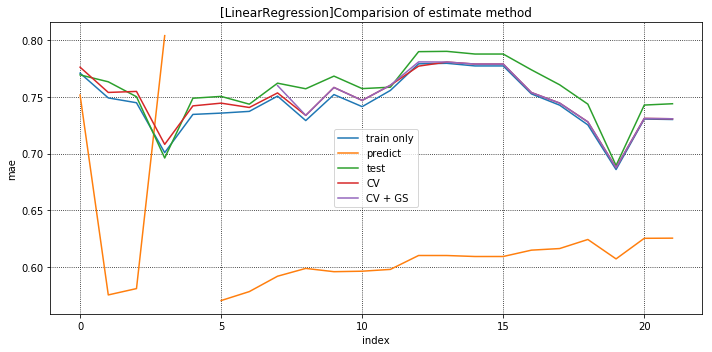

In [33]:
# グラフによる線形回帰モデルの比較
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.set_title('[LinearRegression]Comparision of estimate method')
ax.plot(lenearregression_mae.keys(),
           lenearregression_mae.values(), label='train only')
ax.plot(lenearregression_predict_mae.keys(),
           lenearregression_predict_mae.values(), label='predict')
ax.plot(lenearregression_test_mae.keys(),
           lenearregression_test_mae.values(), label='test')
ax.plot(lenearregression_cv_mae.keys(),
           lenearregression_cv_mae.values(), label='CV')
ax.plot(lenearregression_gs_mae.keys(),
           lenearregression_gs_mae.values(), label='CV + GS')

ax.set_xlabel('index')
ax.set_ylabel('mae')
ax.grid(which='major', color='black', linestyle=':')
ax.grid(which='minor', color='black', linestyle=':')
ax.legend()

fig.tight_layout()
fig.show()

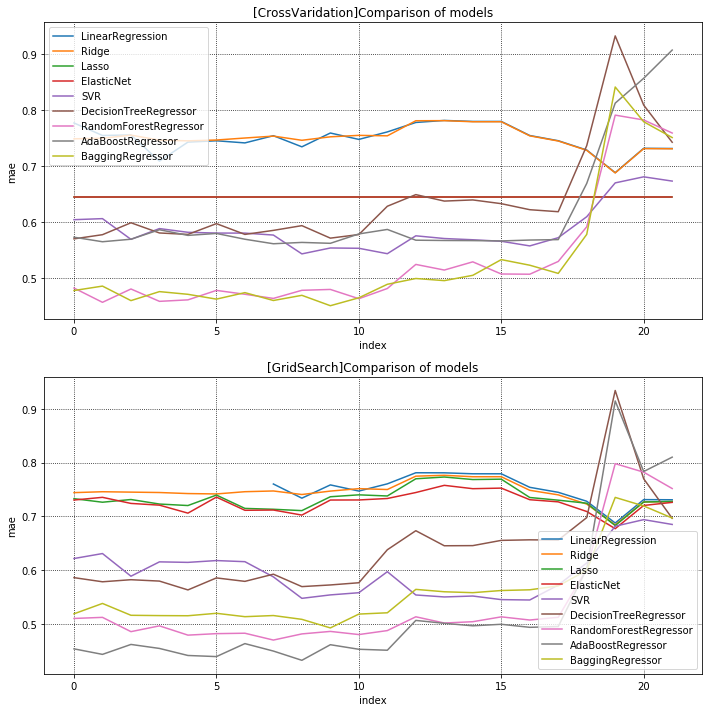

In [34]:
# グラフによるモデル毎の比較
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# モデル毎の比較（クロスバリデーション法）
ax[0].set_title('[CrossVaridation]Comparison of models')
ax[0].plot(lenearregression_cv_mae.keys(), 
           lenearregression_cv_mae.values(), label='LinearRegression')
ax[0].plot(ridge_cv_mae.keys(), ridge_cv_mae.values(), label='Ridge')
ax[0].plot(lasso_cv_mae.keys(), lasso_cv_mae.values(), label='Lasso')
ax[0].plot(elasticnet_cv_mae.keys(),
           elasticnet_cv_mae.values(), label='ElasticNet')
ax[0].plot(svr_cv_mae.keys(), svr_cv_mae.values(), label='SVR')
ax[0].plot(decisiontreeregressor_cv_mae.keys(), 
           decisiontreeregressor_cv_mae.values(), label='DecisionTreeRegressor')
ax[0].plot(randomforestregressor_cv_mae.keys(), 
           randomforestregressor_cv_mae.values(), label='RandomForestRegressor')
ax[0].plot(adaboostregressor_cv_mae.keys(), 
           adaboostregressor_cv_mae.values(), label='AdaBoostRegressor')
ax[0].plot(baggingregressor_cv_mae.keys(), 
           baggingregressor_cv_mae.values(), label='BaggingRegressor')

# モデル毎の比較（クロスバリデーション法＋グリッドサーチ法）
ax[1].set_title('[GridSearch]Comparison of models')
ax[1].plot(lenearregression_gs_mae.keys(), 
           lenearregression_gs_mae.values(), label='LinearRegression')
ax[1].plot(ridge_gs_mae.keys(), ridge_gs_mae.values(), label='Ridge')
ax[1].plot(lasso_gs_mae.keys(), lasso_gs_mae.values(), label='Lasso')
ax[1].plot(elasticnet_gs_mae.keys(),
           elasticnet_gs_mae.values(), label='ElasticNet')
ax[1].plot(svr_gs_mae.keys(), svr_gs_mae.values(), label='SVR')
ax[1].plot(decisiontreeregressor_gs_mae.keys(), 
           decisiontreeregressor_gs_mae.values(), label='DecisionTreeRegressor')
ax[1].plot(randomforestregressor_gs_mae.keys(), 
           randomforestregressor_gs_mae.values(), label='RandomForestRegressor')
ax[1].plot(adaboostregressor_gs_mae.keys(), 
           adaboostregressor_gs_mae.values(), label='AdaBoostRegressor')
ax[1].plot(baggingregressor_gs_mae.keys(), 
           baggingregressor_gs_mae.values(), label='BaggingRegressor')

for i in range(2):
    ax[i].set_xlabel('index')
    ax[i].set_ylabel('mae')
    ax[i].grid(which='major', color='black', linestyle=':')
    ax[i].grid(which='minor', color='black', linestyle=':')
    ax[i].legend()

fig.tight_layout()
fig.show()

No handles with labels found to put in legend.


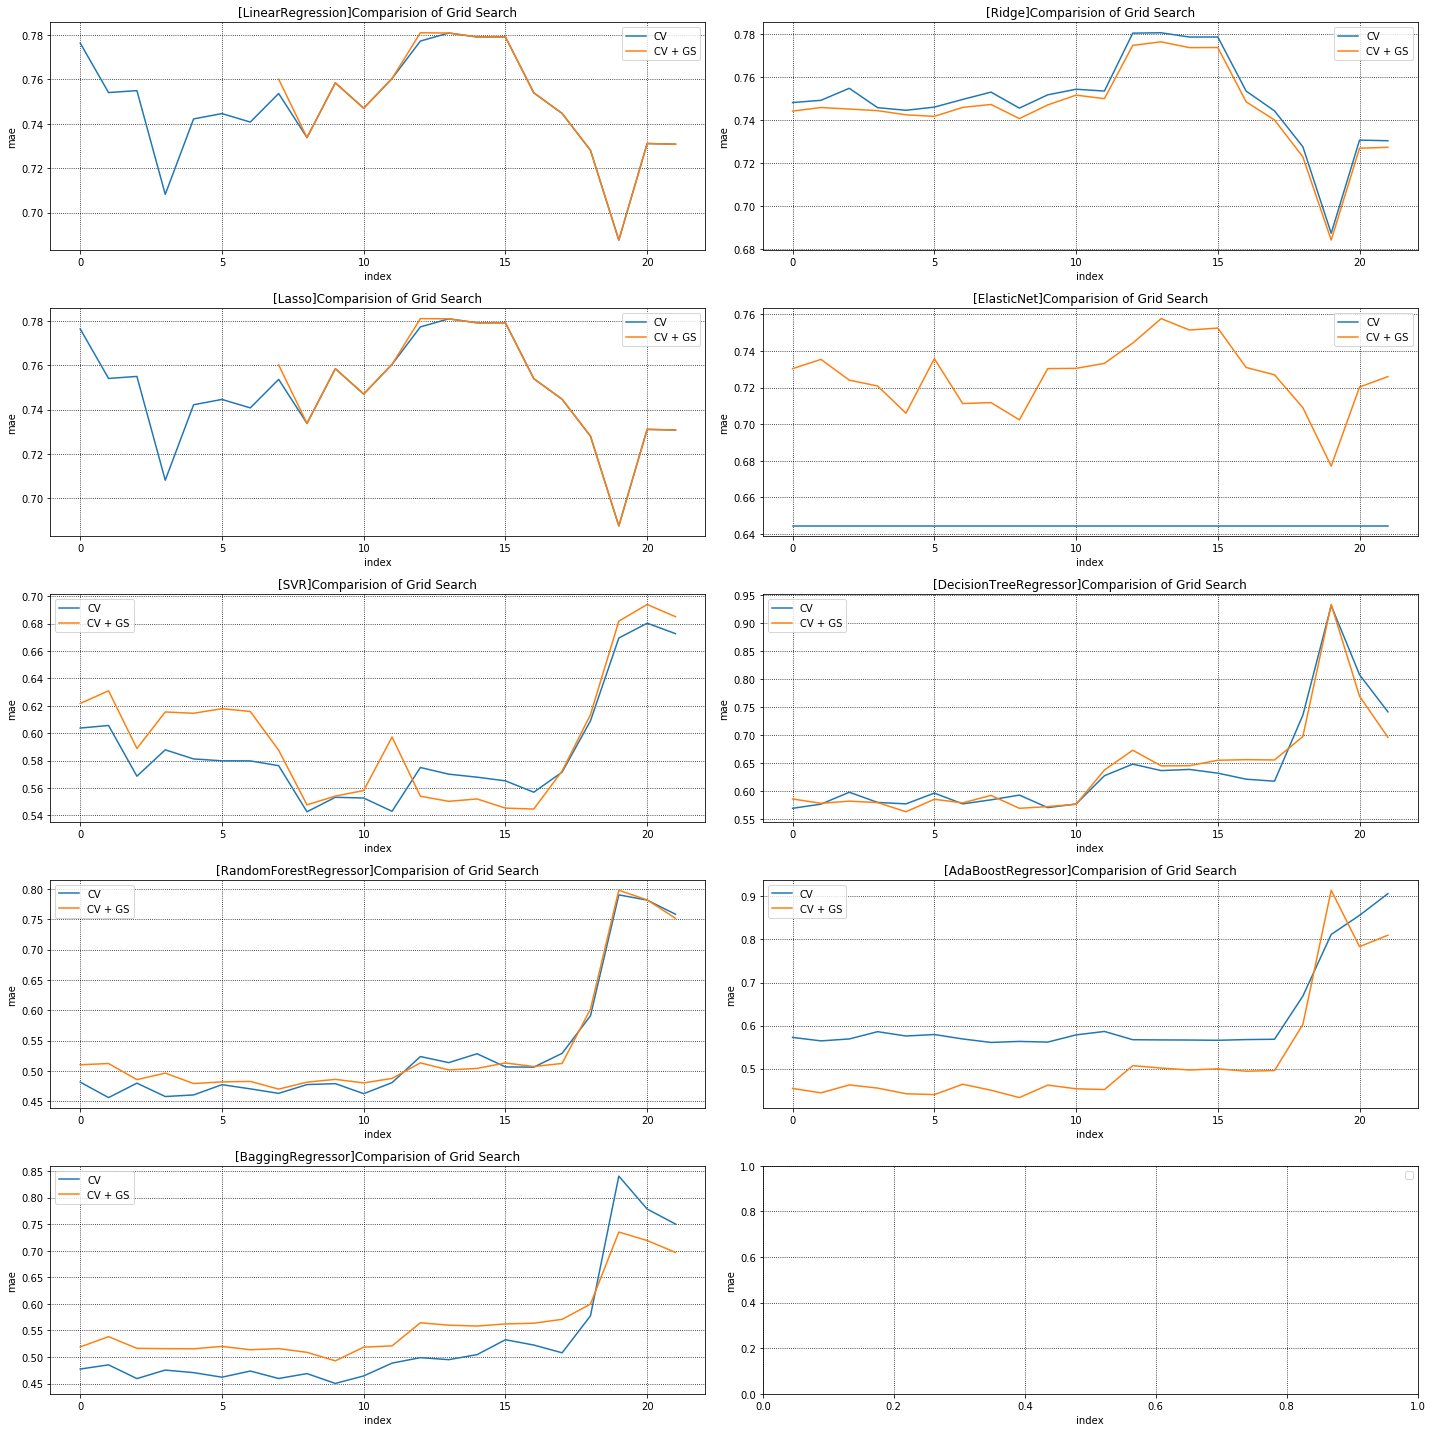

In [35]:
# グラフによるグリッドサーチ法有無の比較
graph_num = 9
fig, ax = plt.subplots(5, 2, figsize=(20, 20))

# グリッドサーチ法有無の比較(LinearRegression)
ax[0][0].set_title('[LinearRegression]Comparision of Grid Search')
ax[0][0].plot(lenearregression_cv_mae.keys(),
           lenearregression_cv_mae.values(), label='CV')
ax[0][0].plot(lenearregression_gs_mae.keys(),
           lenearregression_gs_mae.values(), label='CV + GS')

# グリッドサーチ法有無の比較(Ridge)
ax[0][1].set_title('[Ridge]Comparision of Grid Search')
ax[0][1].plot(ridge_cv_mae.keys(), ridge_cv_mae.values(), label='CV')
ax[0][1].plot(ridge_gs_mae.keys(), ridge_gs_mae.values(), label='CV + GS')

# グリッドサーチ法有無の比較(Lasso)
ax[1][0].set_title('[Lasso]Comparision of Grid Search')
ax[1][0].plot(lenearregression_cv_mae.keys(),
           lenearregression_cv_mae.values(), label='CV')
ax[1][0].plot(lenearregression_gs_mae.keys(),
           lenearregression_gs_mae.values(), label='CV + GS')

# グリッドサーチ法有無の比較(ElasticNet)
ax[1][1].set_title('[ElasticNet]Comparision of Grid Search')
ax[1][1].plot(elasticnet_cv_mae.keys(), elasticnet_cv_mae.values(), label='CV')
ax[1][1].plot(elasticnet_gs_mae.keys(),
           elasticnet_gs_mae.values(), label='CV + GS')

# グリッドサーチ法有無の比較(SVR)
ax[2][0].set_title('[SVR]Comparision of Grid Search')
ax[2][0].plot(svr_cv_mae.keys(), svr_cv_mae.values(), label='CV')
ax[2][0].plot(svr_gs_mae.keys(), svr_gs_mae.values(), label='CV + GS')

# グリッドサーチ法有無の比較(DecisionTreeRegressor)
ax[2][1].set_title('[DecisionTreeRegressor]Comparision of Grid Search')
ax[2][1].plot(decisiontreeregressor_cv_mae.keys(), decisiontreeregressor_cv_mae.values(), label='CV')
ax[2][1].plot(decisiontreeregressor_gs_mae.keys(), decisiontreeregressor_gs_mae.values(), label='CV + GS')

# グリッドサーチ法有無の比較(RandomForestRegressor)
ax[3][0].set_title('[RandomForestRegressor]Comparision of Grid Search')
ax[3][0].plot(randomforestregressor_cv_mae.keys(), randomforestregressor_cv_mae.values(), label='CV')
ax[3][0].plot(randomforestregressor_gs_mae.keys(), randomforestregressor_gs_mae.values(), label='CV + GS')

# グリッドサーチ法有無の比較(AdaBoostRegressor)
ax[3][1].set_title('[AdaBoostRegressor]Comparision of Grid Search')
ax[3][1].plot(adaboostregressor_cv_mae.keys(), adaboostregressor_cv_mae.values(), label='CV')
ax[3][1].plot(adaboostregressor_gs_mae.keys(), adaboostregressor_gs_mae.values(), label='CV + GS')

# グリッドサーチ法有無の比較(BaggingRegressor)
ax[4][0].set_title('[BaggingRegressor]Comparision of Grid Search')
ax[4][0].plot(baggingregressor_cv_mae.keys(), baggingregressor_cv_mae.values(), label='CV')
ax[4][0].plot(baggingregressor_gs_mae.keys(), baggingregressor_gs_mae.values(), label='CV + GS')

for i in range(5):
    for j in range(2):
        ax[i][j].set_xlabel('index')
        ax[i][j].set_ylabel('mae')
        ax[i][j].grid(which='major', color='black', linestyle=':')
        ax[i][j].grid(which='minor', color='black', linestyle=':')
        ax[i][j].legend()

fig.tight_layout()
fig.show()

#### 定量評価

In [36]:
# 説明変数毎の精度
min_cv_mae = {}
min_cv_model = {}
min_gs_mae = {}
min_gs_model = {}
best_gs_best_params = {}
best_gs_best_score = {}

# 説明変数数毎
for i in final_cv_mae:
    # クロスバリデーション法の最小値
    min_cv_mae[i] = min(final_cv_mae[i].values())
    min_cv_model[i] = [
        k for k, v in final_cv_mae[i].items() if v == min_cv_mae[i]
    ]

    # クロスバリデーション法＋グリッドサーチ法の最小値
    min_gs_mae[i] = min(final_gs_mae[i].values())
    min_gs_model[i] = [
        k for k, v in final_gs_mae[i].items() if v == min_gs_mae[i]
    ]
    best_gs_best_params[i] = final_gs_best_params[i][min_gs_model[i][0]]
    best_gs_best_score[i] = final_gs_best_score[i][min_gs_model[i][0]]

In [37]:
# normatl法の最適解
total_min_cv_mae = min(min_cv_mae.values())
total_cv_index = [k for k, v in min_cv_mae.items() if v == total_min_cv_mae]
total_min_cv_model = min_cv_model[total_cv_index[0]]

print('\n-----------------------------------')
print('<normal法>')
print('<クロスバリデーション法>')
print('index = {}'.format(total_cv_index[0]))
print('説明変数 = {}'.format(final_exp_data[total_cv_index[0]].index))
print("モデル = {}".format(total_min_cv_model))
print("MAE = {}".format(round(total_min_cv_mae, 3)))

total_min_gs_mae = min(min_gs_mae.values())
total_gs_index = [k for k, v in min_gs_mae.items() if v == total_min_gs_mae]
total_min_gs_model = min_gs_model[total_gs_index[0]]

print('\n<クロスバリデーション法＋グリッドサーチ法>')
print('index = {}'.format(total_gs_index[0]))
print('説明変数 = {}'.format(final_exp_data[total_gs_index[0]].index))
print("モデル = {}".format(total_min_gs_model))
print("MAE = {}".format(round(total_min_gs_mae, 3)))
print("Grid Search best param = {}".format(
    final_gs_best_params[total_gs_index[0]][total_min_gs_model[0]]))
print("Grid Search best score = {}".format(
    final_gs_best_score[total_gs_index[0]][total_min_gs_model[0]]))


-----------------------------------
<normal法>
<クロスバリデーション法>
index = 9
説明変数 = Index(['AC', '[s]AC snow', 'distance', '[s]rain', '[new]rain', '[s]sun',
       '[new]sun', 'sun', 'time_h', 'speed', 'rain', 'temp_diff',
       'temp_outside'],
      dtype='object')
モデル = ['BaggingRegressor']
MAE = 0.45

<クロスバリデーション法＋グリッドサーチ法>
index = 8
説明変数 = Index(['[s]AC rain', 'AC', '[s]AC snow', 'distance', '[s]rain', '[new]rain',
       '[s]sun', '[new]sun', 'sun', 'time_h', 'speed', 'rain', 'temp_diff',
       'temp_outside'],
      dtype='object')
モデル = ['AdaBoostRegressor']
MAE = 0.433
Grid Search best param = {'base_estimator': DecisionTreeRegressor(criterion='mae', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best'), 'random_state': 1234}
Grid Search best score = 0.517793650495

### 特徴選択-ラッパー法（ステップワイズ法）
#### モデルの学習と評価

In [38]:
def stepwise_remove_feature(X, y, train_data, model):
    """ステップワイズ法を使って特徴を削除"""
    
    # estimatorにモデルをセット
    estimator = model
    
    # RFECVは交差検証によってステップワイズ法による特徴選択を行う
    # cvにはFold（=グループ）の数，scoringには評価指標を指定する
    # 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
    rfecv = RFECV(estimator, cv=10, scoring='neg_mean_absolute_error')

    # fitで特徴選択を実行
    rfecv.fit(X, y)

    # # 特徴数とスコアの変化をプロット
    # # 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
    # plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    # plt.show()

    # bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
    # ここでTrueになっている特徴が削除してもよい特徴
    remove_idx = ~rfecv.support_

    # 削除してもよい特徴の名前を取得する
    remove_feature = train_data.columns[remove_idx]

    # drop関数で特徴を削除
    selected_train_data = train_data.drop(remove_feature, axis=1)
    print("selected_train_data: \n{}".format(selected_train_data.columns))

    return selected_train_data

In [39]:
%%time
mse, mae, rmse = {}, {}, {}
predict_mae, test_mae = {}, {}
cv_mae = {}
gs_best_params, gs_best_score, gs_mae = {}, {}, {}
stepwise_selected_train_data = {}

# RFECVは説明変数の順番でランキングが変わるため、
# 今回は相関係数の絶対値でソートしたものを使う
# train_data = df_data.drop('consume', axis=1)
exp_data = sorted_consume_corr.drop('consume')
train_data = df_data[exp_data.index]
train_label = df_data['consume']
print("\nall: \n{}".format(train_data.columns))

# モデルとパラメタの設定
evaluate_models = get_evaluate_models_and_params()

# evaluate_modelsに設定したモデルを順番に評価
# グリッドサーチ以外はパラメタはデフォルト値
for key, model in tqdm(evaluate_models.items()):
    print('\n<', key, '>')
    
    # TODO エラー出るので除外
    if key == 'SVR' or key == 'BaggingRegressor':
        print('エラー出るのでskip')
        continue

    X = train_data.values
    y = train_label.values

    # ステップワイズ法を使って特徴を削除
    selected_train_data = stepwise_remove_feature(X, y, train_data, model['model'])
    
    stepwise_selected_train_data[key] = selected_train_data.columns
    X = selected_train_data.values
    
    # 訓練誤差のみ
    mse[key], mae[key], rmse[key] = evaluate_normal_precision(
        X, y, model['model'], model['pre_process_flg']
    )

    # ホールドアウト法
    predict_mae[key], test_mae[key] = evaluate_hold_out(
        X, y, model['model'], model['pre_process_flg']
    )

    # クロスバリデーション法
    cv_mae[key] = evaluate_cross_varidation(
        X, y, model['model'], model['pre_process_flg']
    )

    # クロスバリデーション法+グリッドサーチ法
    gs_mae[key], gs_best_params[key], gs_best_score[key] = evaluate_grid_search(
        X, y, model['model'], model['parameters'], model['pre_process_flg']
    )


all: 
Index(['[s]half rain half sun', 'gas_type', '[s]snow', 'temp_inside',
       '[s]AC sun', '[new]AC', '[s]AC', 'heating_off', '[s]AC rain', 'AC',
       '[s]AC snow', 'distance', '[s]rain', '[new]rain', '[s]sun', '[new]sun',
       'sun', 'time_h', 'speed', 'rain', 'temp_diff', 'temp_outside'],
      dtype='object')



< LinearRegression >
selected_train_data: 
Index(['[s]half rain half sun', 'gas_type', '[s]snow', 'temp_inside',
       '[s]AC sun', '[new]AC', '[s]AC', 'heating_off', '[s]AC rain', 'AC',
       '[s]AC snow', 'distance', '[s]rain', '[new]rain', '[s]sun', '[new]sun',
       'sun', 'time_h', 'speed', 'rain', 'temp_outside'],
      dtype='object')

< Ridge >
selected_train_data: 
Index(['[s]half rain half sun', 'gas_type', '[s]snow', 'temp_inside',
       '[s]AC sun', '[new]AC', '[s]AC', 'heating_off', '[s]AC rain', 'AC',
       '[s]AC snow', 'distance', '[s]rain', '[new]rain', '[s]sun', '[new]sun',
       'sun', 'time_h', 'speed', 'rain', 'temp_outside'],
      dtype='object')

< Lasso >
selected_train_data: 
Index(['speed', 'temp_outside'], dtype='object')

< ElasticNet >
selected_train_data: 
Index(['temp_outside'], dtype='object')

< SVR >
エラー出るのでskip

< DecisionTreeRegressor >
selected_train_data: 
Index(['distance', 'time_h', 'temp_outside'], dtype='object')

< RandomForestRegresso

#### 定性評価

In [40]:
# データが尖ってる場合、グラフで比較出来ないので、指定数以上の誤差は仮の値にする
comp_error_list = [
    mse, 
    mae,
    rmse,
    predict_mae,
    test_mae,
    cv_mae,
    gs_mae
]

for models_error in comp_error_list:
    for model, error in models_error.items():
        if error >= 1.0:
            print(model, error)
            models_error[model] = 1.0

LinearRegression 1.0584396369648994
LinearRegression 1.028804955744722
LinearRegression 5.319809529356486
LinearRegression 2.39232545630217


In [41]:
# # TODO 何をグラフ化するかは後で調整

# # グラフによるステップワイズ法比較
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# ax.set_title('[all]Comparision of stepwise method')
# ax.plot(mse.keys(), mse.values(), label='mse')
# ax.plot(mae.keys(), mae.values(), label='mae')
# ax.plot(rmse.keys(), rmse.values(), label='rmse')
# ax.plot(predict_mae.keys(), predict_mae.values(), label='predict_mae')
# ax.plot(test_mae.keys(), test_mae.values(), label='test_mae')
# ax.plot(cv_mae.keys(), cv_mae.values(), label='cv')
# ax.plot(gs_mae.keys(), gs_mae.values(), label='cv+gs')

# ax.set_xlabel('model')
# ax.set_ylabel('mae')
# ax.grid(which='major', color='black', linestyle=':')
# ax.grid(which='minor', color='black', linestyle=':')
# ax.legend()

# fig.tight_layout()
# fig.show()

#### 定量評価

In [42]:
# ステップワいず法の最適解
print('\n-----------------------------------')
print('<ステップワイズ法>')
print('<クロスバリデーション法>')
stepwise_min_cv_mae = min(cv_mae.values())
stepwise_min_cv_mae_model = [k for k, v in cv_mae.items() if v == stepwise_min_cv_mae]
print("説明変数 = {}".format(stepwise_selected_train_data[stepwise_min_cv_mae_model[0]]))
print("モデル = {}".format(stepwise_min_cv_mae_model))
print("MAE = {}".format(round(stepwise_min_cv_mae, 3)))

print('\n<クロスバリデーション法＋グリッドサーチ法>')
stepwise_min_gs_mae = min(gs_mae.values())
stepwise_min_gs_mae_model = [k for k, v in gs_mae.items() if v == stepwise_min_gs_mae]
print("説明変数 = {}".format(stepwise_selected_train_data[stepwise_min_gs_mae_model[0]]))
print("モデル = {}".format(stepwise_min_gs_mae_model))
print("MAE = {}".format(round(stepwise_min_gs_mae, 3)))


-----------------------------------
<ステップワイズ法>
<クロスバリデーション法>
説明変数 = Index(['gas_type', 'temp_inside', 'distance', 'time_h', 'speed', 'rain',
       'temp_diff', 'temp_outside'],
      dtype='object')
モデル = ['RandomForestRegressor']
MAE = 0.479

<クロスバリデーション法＋グリッドサーチ法>
説明変数 = Index(['gas_type', 'temp_inside', '[s]AC snow', 'distance', '[s]rain',
       '[new]rain', 'sun', 'time_h', 'speed', 'rain', 'temp_diff',
       'temp_outside'],
      dtype='object')
モデル = ['AdaBoostRegressor']
MAE = 0.45


### 特徴選択-埋め込み法（LASSO）
#### モデルの学習と評価

In [43]:
def lasso_remove_feature(X, y, train_data):
    """lasso法を使って特徴を削除"""

    # estimatorにモデルをセット
    # LassoCVを使って、正則化の強さは自動決定
    estimator = LassoCV(normalize=True, cv=10)

    # モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
    # 今回は係数が1e-5以下である特徴を削除する
    # 係数のしきい値はthresholdで指定する
    sfm = SelectFromModel(estimator, threshold=1e-5)

    # fitで特徴選択を実行
    sfm.fit(X, y)

#     # LASSOで得た各特徴の係数の値を確認
#     # 係数の絶対値を取得
#     abs_coef = np.abs(sfm.estimator_.coef_)
#     # 係数を棒グラフで表示
#     plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=train_data.columns.values)
#     plt.show()

    # 削除すべき特徴の名前を取得 
    remove_idx  = ~sfm.get_support()

    # 削除してもよい特徴の名前を取得する
    remove_feature = train_data.columns[remove_idx]

    # drop関数で特徴を削除
    selected_train_data = train_data.drop(remove_feature, axis=1)
    print("selected_train_data: \n{}".format(selected_train_data.columns))
    
    return selected_train_data

In [44]:
%%time
mse, mae, rmse = {}, {}, {}
predict_mae, test_mae = {}, {}
cv_mae = {}
gs_best_params, gs_best_score, gs_mae = {}, {}, {}
lasso_selected_train_data = []

# RFECVに合わせて、LassoCVも相関係数の絶対値でソートしたものを使う
# train_data = df_data.drop('consume', axis=1)
exp_data = sorted_consume_corr.drop('consume')
train_data = df_data[exp_data.index]
train_label = df_data['consume']
print("\nall: \n{}".format(train_data.columns))

X = train_data.values
y = train_label.values

# lasso法を使って特徴を削除
selected_train_data = lasso_remove_feature(X, y, train_data)

lasso_selected_train_data = selected_train_data.columns
X = selected_train_data.values

# モデルとパラメタの設定
evaluate_models = get_evaluate_models_and_params()

# evaluate_modelsに設定したモデルを順番に評価
# グリッドサーチ以外はパラメタはデフォルト値
for key, model in tqdm(evaluate_models.items()):
    print('<', key, '>')

    # 訓練誤差のみ
    mse[key], mae[key], rmse[key] = evaluate_normal_precision(
        X, y, model['model'], model['pre_process_flg']
    )

    # ホールドアウト法
    predict_mae[key], test_mae[key] = evaluate_hold_out(
        X, y, model['model'], model['pre_process_flg']
    )

    # クロスバリデーション法
    cv_mae[key] = evaluate_cross_varidation(
        X, y, model['model'], model['pre_process_flg']
    )

    # クロスバリデーション法+グリッドサーチ法
    gs_mae[key], gs_best_params[key], gs_best_score[key] = evaluate_grid_search(
        X, y, model['model'], model['parameters'], model['pre_process_flg']
    )


all: 
Index(['[s]half rain half sun', 'gas_type', '[s]snow', 'temp_inside',
       '[s]AC sun', '[new]AC', '[s]AC', 'heating_off', '[s]AC rain', 'AC',
       '[s]AC snow', 'distance', '[s]rain', '[new]rain', '[s]sun', '[new]sun',
       'sun', 'time_h', 'speed', 'rain', 'temp_diff', 'temp_outside'],
      dtype='object')
selected_train_data: 
Index(['[s]half rain half sun', 'gas_type', '[s]snow', 'temp_inside',
       '[s]AC sun', '[new]AC', 'heating_off', '[s]AC rain', 'AC', '[s]AC snow',
       'distance', 'sun', 'time_h', 'speed', 'rain', 'temp_outside'],
      dtype='object')


< LinearRegression >
< Ridge >
< Lasso >
< ElasticNet >
< SVR >
< DecisionTreeRegressor >
< RandomForestRegressor >
< AdaBoostRegressor >
< BaggingRegressor >

CPU times: user 21.4 s, sys: 166 ms, total: 21.6 s
Wall time: 21.8 s


#### 定性評価

In [45]:
# データが尖ってる場合、グラフで比較出来ないので、指定数以上の誤差は仮の値にする
comp_error_list = [
    mse, 
    mae,
    rmse,
    predict_mae,
    test_mae,
    cv_mae,
    gs_mae
]

for models_error in comp_error_list:
    for model, error in models_error.items():
        if error >= 1.0:
            print(model, error)
            models_error[model] = 1.0

DecisionTreeRegressor 1.1826282051282049
DecisionTreeRegressor 1.087487105729629


In [46]:
# # TODO 何をグラフ化するかは後で調整

# # グラフによるlasso法比較
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# ax.set_title('[all]Comparision of lasso method')
# ax.plot(mse.keys(), mse.values(), label='mse')
# ax.plot(mae.keys(), mae.values(), label='mae')
# ax.plot(rmse.keys(), rmse.values(), label='rmse')
# ax.plot(predict_mae.keys(), predict_mae.values(), label='predict_mae')
# ax.plot(test_mae.keys(), test_mae.values(), label='test_mae')
# ax.plot(cv_mae.keys(), cv_mae.values(), label='cv')
# ax.plot(gs_mae.keys(), gs_mae.values(), label='cv+gs')

# ax.set_xlabel('model')
# ax.set_ylabel('mae')
# ax.grid(which='major', color='black', linestyle=':')
# ax.grid(which='minor', color='black', linestyle=':')
# ax.legend()

# fig.tight_layout()
# fig.show()

#### 定量評価

In [47]:
# LASSO法の最適解
print('\n-----------------------------------')
print('<LASSO法>')
print('<クロスバリデーション法>')
lasso_min_cv_mae = min(cv_mae.values())
lasso_min_cv_mae_model = [k for k, v in cv_mae.items() if v == lasso_min_cv_mae]
print("説明変数 = {}".format(lasso_selected_train_data))
print("モデル = {}".format(lasso_min_cv_mae_model))
print("MAE = {}".format(round(lasso_min_cv_mae, 3)))

print('\n<クロスバリデーション法＋グリッドサーチ法>')
lasso_min_gs_mae = min(gs_mae.values())
lasso_min_gs_mae_model = [k for k, v in gs_mae.items() if v == lasso_min_gs_mae]
print("説明変数 = {}".format(lasso_selected_train_data))
print("モデル = {}".format(lasso_min_gs_mae_model))
print("MAE = {}".format(round(lasso_min_gs_mae, 3)))


-----------------------------------
<LASSO法>
<クロスバリデーション法>
説明変数 = Index(['[s]half rain half sun', 'gas_type', '[s]snow', 'temp_inside',
       '[s]AC sun', '[new]AC', 'heating_off', '[s]AC rain', 'AC', '[s]AC snow',
       'distance', 'sun', 'time_h', 'speed', 'rain', 'temp_outside'],
      dtype='object')
モデル = ['BaggingRegressor']
MAE = 0.454

<クロスバリデーション法＋グリッドサーチ法>
説明変数 = Index(['[s]half rain half sun', 'gas_type', '[s]snow', 'temp_inside',
       '[s]AC sun', '[new]AC', 'heating_off', '[s]AC rain', 'AC', '[s]AC snow',
       'distance', 'sun', 'time_h', 'speed', 'rain', 'temp_outside'],
      dtype='object')
モデル = ['AdaBoostRegressor']
MAE = 0.456


### 特徴選択の比較

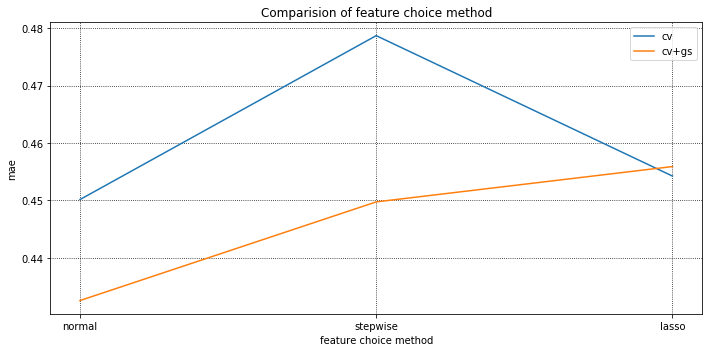

In [48]:
# TODO 何をグラフ化するかは後で調整

# # グラフによる特徴選択の比較
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

index = ['normal', 'stepwise', 'lasso']
label_cv = [total_min_cv_mae, stepwise_min_cv_mae, lasso_min_cv_mae]
label_gs = [total_min_gs_mae, stepwise_min_gs_mae, lasso_min_gs_mae]

ax.set_title('Comparision of feature choice method')
ax.plot(index, label_cv, label='cv')
ax.plot(index, label_gs, label='cv+gs')

ax.set_xlabel('feature choice method')
ax.set_ylabel('mae')
ax.grid(which='major', color='black', linestyle=':')
ax.grid(which='minor', color='black', linestyle=':')
ax.legend()

fig.tight_layout()
fig.show()

In [49]:
# 特徴選択の比較
print('\n-----------------------------------')
print('<クロスバリデーション法>')
total_min = min([total_min_cv_mae, stepwise_min_cv_mae, lasso_min_cv_mae])

if total_min == total_min_cv_mae:
    print('<normal法>')
    feature = final_exp_data[total_cv_index[0]].index
    model = total_min_cv_model
    mae = total_min_cv_mae
elif total_min == stepwise_min_cv_mae:
    print('<ステップワイズ法>')
    feature = stepwise_selected_train_data[stepwise_min_cv_mae_model[0]]
    model = stepwise_min_cv_mae_model
    mae = stepwise_min_cv_mae
elif total_min == lasso_min_cv_mae:
    print('<LASSO法>')
    feature = lasso_selected_train_data
    model = lasso_min_cv_mae_model
    mae = lasso_min_cv_mae
    
print("説明変数 = {}".format(feature))
print("モデル = {}".format(model))
print("MAE = {}".format(round(mae, 3)))

print('\n<クロスバリデーション法＋グリッドサーチ法>')
total_min = min([total_min_cv_mae, stepwise_min_cv_mae, lasso_min_cv_mae])

if total_min == total_min_cv_mae:
    print('<normal法>')
    featrue = final_exp_data[total_gs_index[0]].index
    model = total_min_gs_model
    mae = total_min_gs_mae
    
elif total_min == stepwise_min_cv_mae:
    print('<ステップワイズ法>')
    feature = stepwise_selected_train_data[stepwise_min_gs_mae_model[0]]
    model = stepwise_min_gs_mae_model
    mae = stepwise_min_gs_mae

elif total_min == lasso_min_cv_mae:
    print('<LASSO法>')
    feature = lasso_selected_train_data
    model = lasso_min_gs_mae_model
    mae = lasso_min_gs_mae
    
print("説明変数 = {}".format(feature))
print("モデル = {}".format(model))
print("MAE = {}".format(round(mae, 3)))


-----------------------------------
<クロスバリデーション法>
<normal法>
説明変数 = Index(['AC', '[s]AC snow', 'distance', '[s]rain', '[new]rain', '[s]sun',
       '[new]sun', 'sun', 'time_h', 'speed', 'rain', 'temp_diff',
       'temp_outside'],
      dtype='object')
モデル = ['BaggingRegressor']
MAE = 0.45

<クロスバリデーション法＋グリッドサーチ法>
<normal法>
説明変数 = Index(['AC', '[s]AC snow', 'distance', '[s]rain', '[new]rain', '[s]sun',
       '[new]sun', 'sun', 'time_h', 'speed', 'rain', 'temp_diff',
       'temp_outside'],
      dtype='object')
モデル = ['AdaBoostRegressor']
MAE = 0.433


## まとめ
### DAY1検証結果

    <線形回帰 訓練誤差のみを計測>
    <説明変数>
    Index(['distance', 'speed', 'temp_inside', 'temp_outside', 'gas_type', 'AC',
           'rain', 'sun', '[s]AC', '[s]AC rain', '[s]AC snow', '[s]AC sun',
           '[s]half rain half sun', '[s]rain', '[s]snow', '[s]sun'],
          dtype='object')

    <精度>
    MAE = 0.585
    
    ※比較のためMAE以外は省略

### DAY2検証結果
DAY1では説明変数を全て選択した場合に精度が最も高くなったが、DAY2で習得した手法を用いることで、的確な説明変数を選択し前処理や検証法を吟味することで精度を改善することができた。

    無相関化：|相関係数|が0.1以上の説明変数に対して実施
    標準化：全ての説明変数の訓練データ・テストデータに対して実施
    クロスバリデーションのクラス数：5

    <クロスバリデーション法＋グリッドサーチ法>
    説明変数 = Index(['speed', 'distance', 'rain', 'temp_outside', 'time_h'], dtype='object')
    モデル = ['SVR']
    Grid Search best param = {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

    MAE = 0.52　　　　<- ☆DAY1より精度が良くなってる！！！！

#### 前回から取り組んだ内容・工夫、精度がどのように変化したか
##### 前処理
-  説明変数
    - AC,rain,sunとspecialのAC,rain,sunのそれぞれのandを取った新しい説明変数を作成
    - speedとdistanceからh_timeを算出
    - temp_insideとtemp_outsideの差分を取り、新たな説明変数を作成
    - 暖房がまったく使用されなかった場合はフラグを立てる説明変数を作成
    - 'temp_inside'のnaに'temp_outside'を入れる（DAY1ではtemp_insideの平均を入れていたが変更した）

- 前処理
    - 標準化するとモデルの評価時間体感で10倍早く、かつ精度が高かった。ここは標準化するデータに対して変わってくると思うため、引き続き検証が必要
    - 説明変数間の相関係数の絶対値が0.1以上のものに対して無相関化を行ったところ、精度が最も良くなった。無相関化も選択するデータによって変わってくるため、引き続き検証が必要

##### モデルの学習・評価
- 線形回帰モデルで訓練誤差のみとホールドアウト法を比較したところ、訓練誤差よりホールドアウト法の汎化誤差の方が、誤差が大きかった
- 線形回帰モデルでホールドアウト法とクロスバリデーション法を比較したところ、クロスバリデーション法の方が精度が高くなった
- モデル間の比較のため、lenearregression,　Ridge,　Lasso,　ElasticNet,　SVRの精度を比べたところ、SVRが最も精度が高くなった
- グリッドサーチ法有無でクロスバリデーション法の比較を行ったところ、パラメタの調整次第では、グリッドサーチ法を使わない方が精度が高くなる場合もあった

##### その他
- 相関係数の値で繰り返してモデルを評価していたが、説明変数数で繰り返すように修正。その他にもコードは読み易い＆自動化を目指して改善を行った。引き続き継続して、気が付いだ箇所はリファクタリングしていく

### DAY3検証結果
TODO

    無相関化：TODO
    標準化：TODO
    クロスバリデーションのクラス数：5
    
    -----------------------------------
    <クロスバリデーション法>
    <normal法>
    説明変数 = Index(['AC', '[s]AC snow', 'distance', '[s]rain', '[new]rain', '[s]sun',
           '[new]sun', 'sun', 'time_h', 'speed', 'rain', 'temp_diff',
           'temp_outside'],
          dtype='object')
    モデル = ['BaggingRegressor']
    MAE = 0.449

    <クロスバリデーション法＋グリッドサーチ法>
    <normal法>
    説明変数 = Index(['AC', '[s]AC snow', 'distance', '[s]rain', '[new]rain', '[s]sun',
           '[new]sun', 'sun', 'time_h', 'speed', 'rain', 'temp_diff',
           'temp_outside'],
          dtype='object')
    モデル = ['AdaBoostRegressor']
    MAE = 0.433　　　　<- ☆DAY2より精度が良くなってる！！！！

#### 前回から取り組んだ内容・工夫、精度がどのように変化したか
##### 前処理
-  説明変数
    - 型の統一（量的変数はfloat64、質的変数はuint8）
    - TODO
    
- 前処理
    - 標準化 / 正規化
        - 処理のタイミングはtarinとtestに分けた後
        - TODO 質的変数を対象としないー＞精度高くなった
        - ~~タイミングをtarinとtestに分ける前に変更。そのほうが量的変数・質的変数を見分けやすいから~~
        - ↑要修正
        - TODO
    - 無相関化 / 白色化
        - 処理のタイミングはtarinとtestに分けた後
        - TODO 質的変数を対象としないー＞精度高くなった
        - ~~相関係数の絶対値が0.9以上の時に精度が最も高くなった。これはtemp_diffとtemp_outsideだけを無相関化した結果となった~~
        - ↑要修正
        - TODO
    
##### モデルの学習・評価
- 決定木、ランダムフォレスト、アドブースト、バギングを新たに試したところ、ランダムフォレスト、アドブースト、バギングの精度が非常に高かった
- 特徴選択
    - ラッパー法（ステップワイズ法）
        - RFECVは説明変数の順番でランキングが変わるため、今回は相関係数の絶対値でソートしたものでRFECVを行った。
    - 埋め込み法（LassoCV）
        - LassoCVは説明変数の順番は影響しなかった
    - ラッパー法・埋め込み法よりも、最初に試した「相関係数の値で説明変数を徐々に減らしていく方法」が最も精度が良かった
    
##### その他
- 受講者間でMAE等のスコア比較をしやすくするため、同じtrain / testの分割を行い、X_test, y_testは、最後にMAE等の指標を測定する時のみ用いた
- TODO 標準化をすると、ElasticNetの評価値に変化が見られない（どの説明変数を選んでも同じ値になる）。なぜ？
- TODO